# Visualising Results
## Overview
Here we visualise many of the outputs from the SNP- and SV-based population analyses for fairy tern (*Sterna nereis*) populations in Western Australian (*S. n. nereis*) and Aotearoa New Zealand (*S. n. davisae*) as well as the critically endangered kakī (*Himantopus novaezelandiae*). We examine the number proportion, and density of Runs of Homozygosity (ROHs) to compare relative levels of inbreeding. We examine the site frequency spectrum (SFS) for each of the three taxa, and explore structure among fairy tern populations by visualising genome-wide F<sub>ST</sub>, and examining a multidimensional scaling (MDS) analysis generated by NGStools.  

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib.legend_handler import HandlerTuple
import matplotlib.pyplot as plt

path = 'G:\My Drive\Data\S_nereis_ssp\genomic_data'
os.chdir(path)
print(os.getcwd())

G:\My Drive\Data\S_nereis_ssp\genomic_data


## Runs of Homozygosity (ROHs)
First, we estimated the number of short (>50kb & <=200kb in length), medium (>200kb & <=700kb in length) and long (>700kb in length) of ROHs per individual. This is to provide some indication of long-, medium- and short-term inbreeding levels respectively for each of the populations. Here, we can see that tara iti consistently have more ROHs across all three size classes.  

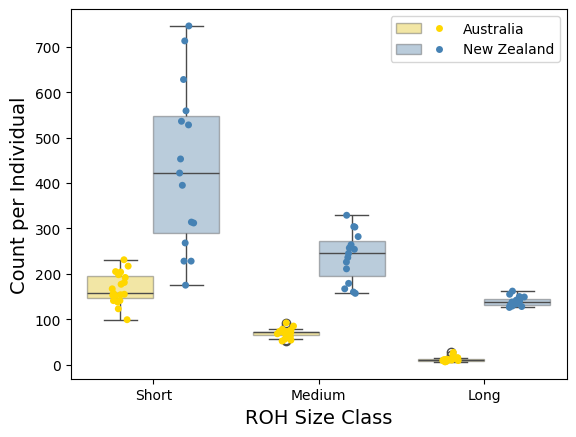

In [100]:
roh = pd.read_csv('ROHAN_out/ROHs2.tsv', delimiter='\t')

xvalues = ["Short ROHs", "Medium ROHs", "Long ROHs"]
palette = ['gold', 'steelblue']

ax = sns.boxplot(data=roh, x="ROH_Class", y="ROH_Count",
                 hue="Population", palette=palette, hue_order=['AU', 'NZ'], boxprops={'alpha': 0.4})
sns.stripplot(data=roh, x="ROH_Class", y="ROH_Count",
              hue="Population", palette=palette, hue_order=['AU', 'NZ'], dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=['Australian Fairy Tern', 'Tara iti'],
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_xlabel('ROH Size Class', fontsize=14)
ax.set_ylabel("Count per Individual", fontsize=14)

plt.savefig('plots/ROH_counts.png', dpi=300, bbox_inches='tight')

We also examined the proportion of the genome impacted by ROHs for each individual of Australian fairy tern and tara iti. The higher count of ROHs in tara iti population also translated to a higher proportion of the genome impacted overall. However, the vast majority of ROHs impacting the genome is attributable to those in the 'large' (>700kb in length) category. This indicates that the tara iti population has remained chronically small for several generations.  

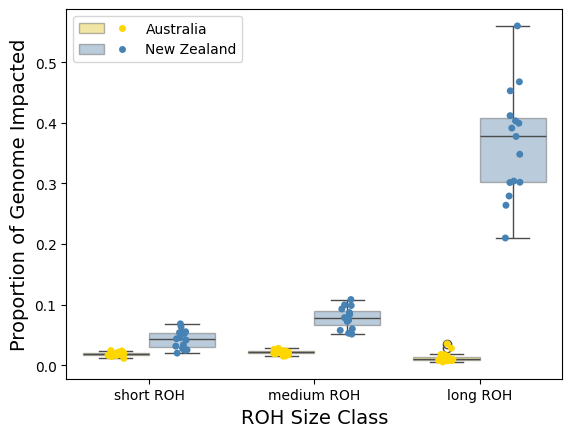

In [99]:
roh_len = pd.read_csv('ROHAN_out/ROH_proportions.tsv', sep='\t')
roh_len['Proportion'] = (roh_len['Sum of ROHs'] / 1200000000)

ax = sns.boxplot(data=roh_len, x="ROH Class", y="Proportion",
                 hue="Population", palette=palette, hue_order=['AU', 'NZ'], boxprops={'alpha': 0.4})
sns.stripplot(data=roh_len, x="ROH Class", y="Proportion",
              hue="Population", palette=palette, hue_order=['AU', 'NZ'], dodge=True, ax=ax)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=['Australian Fairy Tern', 'Tara iti'],
          loc='upper left', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_xlabel('ROH Size Class', fontsize=14)
ax.set_ylabel("Proportion of Genome Impacted", fontsize=14)

plt.savefig('plots/ROH_genome_proportions.png', dpi=300, bbox_inches='tight')

We then examined the density of Runs of Homozygosity (ROHs) by size class. Here, we plot the number of ROHs occurring in a particular location across individuals for chromosome 1. This ROH density indicates whether the populations are impacted by similar ROHs by size class.  

To start, we begin by loading and subsetting the original `ROH_density.tsv` file by population, ROH size class, and the position (`BEGIN` and `END`) of ROHs.  

In [2]:
# Setting variables for plotting ROH density
roh_density = pd.read_csv('ROHAN_out/ROH_density.tsv', sep='\t')
roh_sm = roh_density[(roh_density['ROH_class'] == 'Short ROH') & (roh_density['Chromosome']=='CM020437.1_RagTag')]
roh_md = roh_density[(roh_density['ROH_class'] == 'Medium ROH') & (roh_density['Chromosome']=='CM020437.1_RagTag')]
roh_lg = roh_density[(roh_density['ROH_class'] == 'Long ROH') & (roh_density['Chromosome']=='CM020437.1_RagTag')]

au_roh_sm = roh_sm[roh_sm['Population']=='AU']
au_roh_md = roh_md[roh_md['Population']=='AU']
au_roh_lg = roh_lg[roh_lg['Population']=='AU']

nz_roh_sm = roh_sm[roh_sm['Population']!='AU']
nz_roh_md = roh_md[roh_md['Population']!='AU']
nz_roh_lg = roh_lg[roh_lg['Population']!='AU']

# Ranges of ROH presence
au_sm_presence = au_roh_sm[['BEGIN', 'END']]
au_md_presence = au_roh_md[['BEGIN', 'END']]
au_lg_presence = au_roh_lg[['BEGIN', 'END']]
nz_sm_presence = nz_roh_sm[['BEGIN', 'END']]
nz_md_presence = nz_roh_md[['BEGIN', 'END']]
nz_lg_presence = nz_roh_lg[['BEGIN', 'END']]
# Viewing the data format
nz_lg_presence.head()

,BEGIN,END
15993,1600001,4550000
15994,4650001,7000000
15995,12000001,13100000
15996,15450001,17200000
15997,21200001,25300000


With the aid of ChatGPT3.5, we then defined a plot function that marks the presence/absence of ROHs by their `BEGIN` and `END` position along chromosome 1. Here, we will use the color `seagreen` to denote short ROHs, `wheat` for medium ROHs, and `coral` for large ROHs. The opacity of these regions is adjusted so regions with multiple individuals carrying the same ROHs will be darker.  

In [3]:
def plot_roh_density(df, continuous_range, alpha_multiplier=0.7, plot_color='steelblue'):
    """
    Plot the density of ROHs along the chromosome.

    Parameters:
        df (DataFrame): Input DataFrame containing 'BEGIN' and 'END' columns.
        continuous_range (range or list): Continuous range of positions to consider.
        alpha_multiplier (float): Multiplier to adjust alpha based on the number of overlapping ranges.
        plot_color (str): Color for plotting the presence/absence regions.

    Returns:
        None
    """
    # Iterate over each row in the DataFrame and plot presence regions
    for _, row in df.iterrows():
        start, end = row['BEGIN'], row['END']
        plt.fill_between(range(start, end+1), 0, 1, color=plot_color, alpha=0.5, edgecolor=None)

# Example usage:
# chr_range = range(0, 219000000, 1000)  # Define your chromosome size range in bp here
# plot_roh_density(nz_lg_presence, continuous_range, alpha_multiplier=0.25, plot_color='steelblue')

Finally, we plot ROH density for Australian fairy terns along chromosome 1. Consistent with the above plots, there were overall very few ROHs with the vast majority of them falling under the 'small' ROH size class. Notably, very few of the ROHs overlapped in the Australian fairy tern population.  

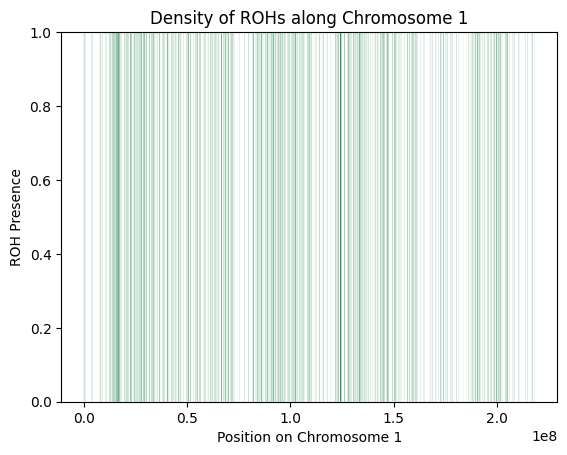

In [ ]:
chr1_size = range(0, 219000000, 1000)

plot_roh_density(au_sm_presence, chr1_size, alpha_multiplier=0.7, plot_color='seagreen')
plot_roh_density(au_md_presence, chr1_size, alpha_multiplier=0.7, plot_color='wheat')
plot_roh_density(au_lg_presence, chr1_size, alpha_multiplier=0.7, plot_color='coral')

# Customize plot
plt.xlabel('Position on Chromosome 1')
plt.ylabel('ROH Presence')
plt.title('Density of ROHs along Chromosome 1')
plt.ylim(0, 1)  # Set y-axis limits to show presence (1) and absence (0)

# Save and show plot
plt.savefig('plots/AU_total_ROH_density.png', dpi=300, bbox_inches='tight')
plt.show()

In contrast to Australian fairy terns, tara iti ROH density was much higher across all three size classes.  

MemoryError: Unable to allocate 139. MiB for an array with shape (36450000, 1) and data type int32

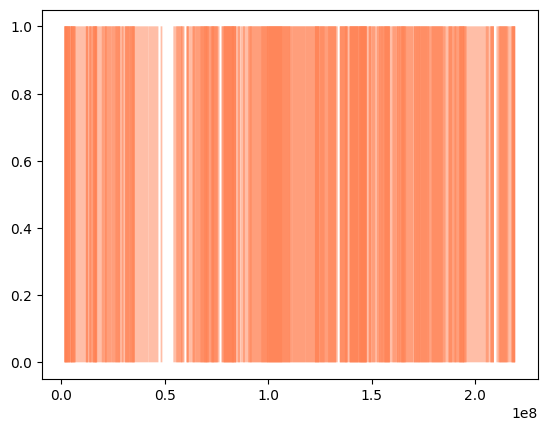

In [4]:
chr1_size = range(0, 219000000, 1000)

#plot_roh_density(nz_sm_presence, chr1_size, alpha_multiplier=0.7, plot_color='seagreen')
#plot_roh_density(nz_md_presence, chr1_size, alpha_multiplier=0.7, plot_color='wheat')
plot_roh_density(nz_lg_presence, chr1_size, alpha_multiplier=0.7, plot_color='coral')

# Customize plot
plt.xlabel('Position on Chromosome 1')
plt.ylabel('ROH Presence')
plt.title('Density of ROHs along Chromosome 1')
plt.ylim(0, 1)  # Set y-axis limits to show presence (1) and absence (0)

# Save and show plot
plt.savefig('plots/NZ_large_ROH_density.png', dpi=300, bbox_inches='tight')
plt.show()

And finally kakī ROH density.  

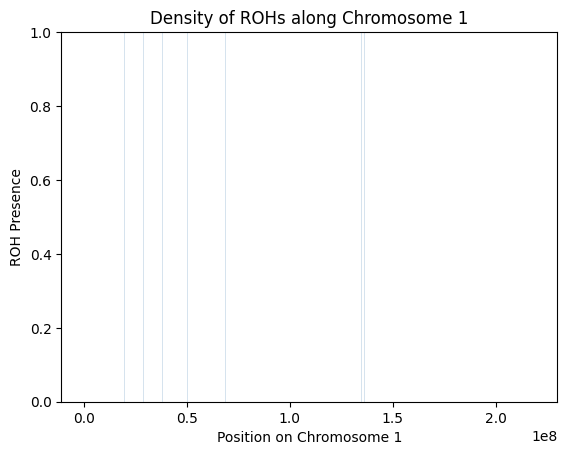

In [5]:
# Initialize lists to store x and y coordinates for the plot
x_coords = []
y_coords = []

# Iterate over the continuous range
for i in continuous_range:
    overlapping_ranges = 0
    for _, row in au_sm_presence.iterrows():
        start, end = row['BEGIN'], row['END']
        if i >= start and i <= end:
            overlapping_ranges += 1
    
    # If there are overlapping ranges, mark presence; otherwise, mark absence
    if overlapping_ranges > 0:
        x_coords.append(i)
        y_coords.append(1)  # Presence
    else:
        x_coords.append(i)
        y_coords.append(0)  # Absence

    # Calculate alpha based on the number of overlapping ranges
    alpha = 1 - np.exp(-overlapping_ranges * 0.25)  # Adjust multiplier as needed
    
    # Plot the presence/absence at this point with the calculated alpha
    plt.fill_between([i, i+100], 0, [y_coords[-1], y_coords[-1]], color='steelblue', alpha=alpha, linewidth=0)

# Customize plot
plt.xlabel('Position on Chromosome 1')
plt.ylabel('ROH Presence')
plt.title('Density of ROHs along Chromosome 1')
plt.ylim(0, 1)  # Set y-axis limits to show presence (1) and absence (0)

# Show plot
plt.show()

Finally, we examined individual heterozygosity as estimated by `ANGSD` and `realSFS` for all sites.  

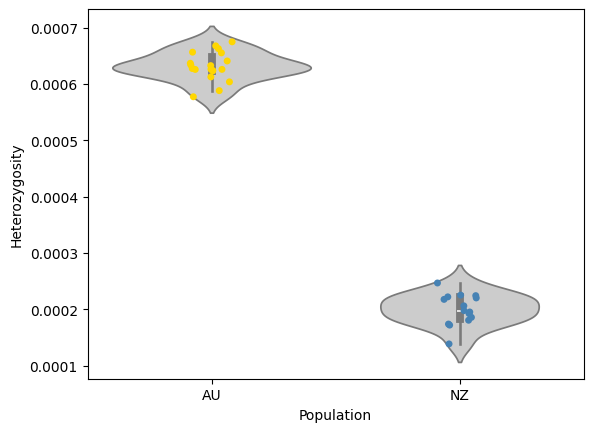

In [36]:
indiv_het = pd.read_csv('angsd/individual_het.tsv', delimiter='\t')
indiv_het.head()

wholegenome_het = indiv_het[indiv_het["Tool"] == 'samtools']

sns.violinplot(data = wholegenome_het, x = "Population", y = "Heterozygosity", color="0.8")
sns.stripplot(data = wholegenome_het, x = "Population", y = "Heterozygosity",
                   hue = "Population", palette=palette, jitter = True)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=[(handles[0], handles[2]), (handles[1], handles[3])],
          labels=['Australia', 'New Zealand'],
          loc='upper right', handlelength=4,
          handler_map={tuple: HandlerTuple(ndivide=None)})
ax.set_xlabel('Population', fontsize=14)
ax.set_ylabel("Heterozygosity", fontsize=14)

plt.savefig('plots/indiv_het_wholeGenome.png')

And for putatively 'neutral' sites where we excluded regions predicted to be coding regions by `AUGUSTUS`.  

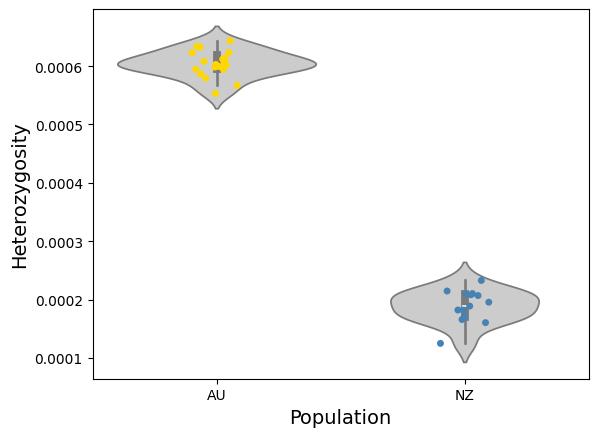

In [37]:
neutral_het = indiv_het[indiv_het["Tool"] == 'NEUTRAL']

ax = sns.violinplot(data = neutral_het, x = "Population", y = "Heterozygosity", color="0.8")
sns.stripplot(data = neutral_het, x = "Population", y = "Heterozygosity",
                   hue = "Population", palette=palette, jitter = True)
handles, labels = ax.get_legend_handles_labels()
ax.set_xlabel('Population', fontsize=14)
ax.set_ylabel("Heterozygosity", fontsize=14)

plt.savefig('plots/indiv_het_neutralSites.png')

## Site Frequency Spectrum
Below we plot the site frequency spectrum (SFS) for putatively neutral sites and whole genome sites as a means to indirectly examine realised and potential genetic load in fairy terns and kakī.  

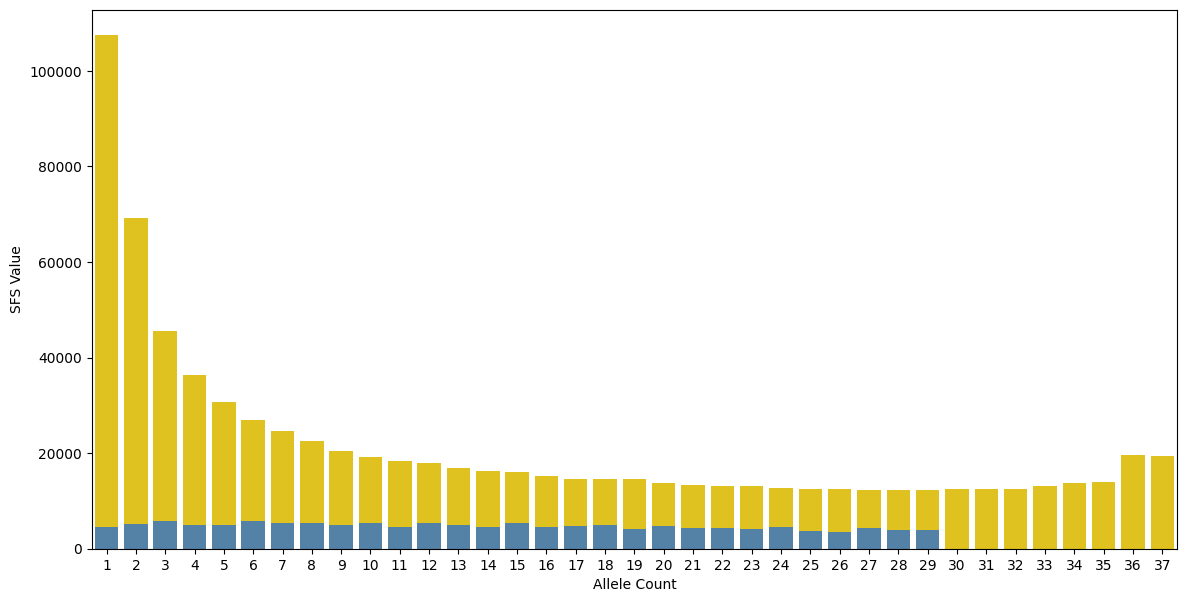

In [48]:
ausfs = pd.read_csv("angsd/sfs/AU_neutral_modified.sfs", sep='\t')
tisfs = pd.read_csv("angsd/sfs/TI_neutral_modified.sfs", sep='\t')

ausfs = ausfs.iloc[1:38]
tisfs = tisfs.iloc[1:30]

plt.figure(figsize=(14,7))
sns.barplot(data=ausfs, x='Allele Count', y='SFS Value', color='gold')
sns.barplot(data=tisfs, x='Allele Count', y='SFS Value', color='steelblue')

plt.savefig('plots/SFS_neutralSites.png')

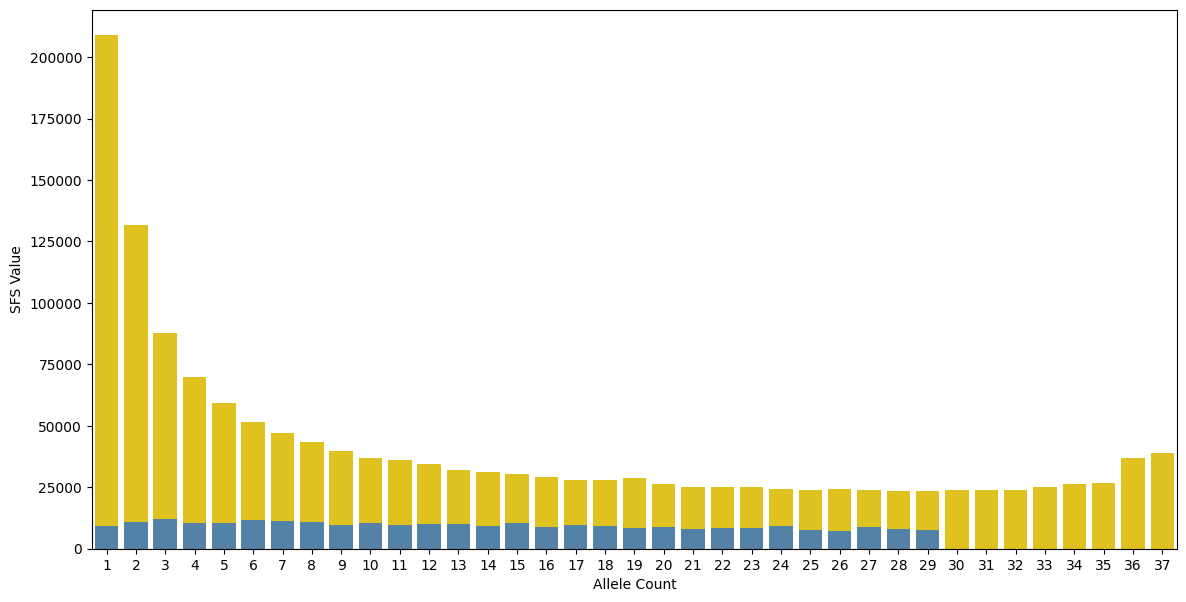

In [59]:
ausfs = pd.read_csv("angsd/sfs/AU_whole-genome_modified.sfs", sep='\t')
tisfs = pd.read_csv("angsd/sfs/TI_whole-genome_modified.sfs", sep='\t')

ausfs = ausfs.iloc[1:38]
tisfs = tisfs.iloc[1:30]

plt.figure(figsize=(14,7))
sns.barplot(data=ausfs, x='Allele Count', y='SFS Value', color='gold')
sns.barplot(data=tisfs, x='Allele Count', y='SFS Value', color='steelblue')

plt.savefig('plots/SFS_whole-genome_Sites.png')

We also attempted to visualise the joint SFS. This wasn't particularly informative as the two populations were so differentiated. That is to say, alleles common in one population were rare or absent in another. As indicated by the high F<sub>ST</sub> plotted below.  

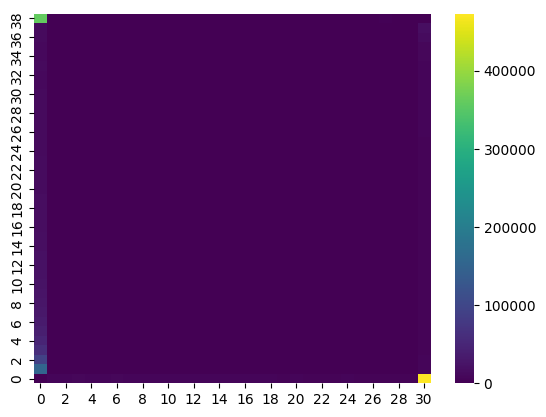

In [103]:
jointsfs = pd.read_csv('angsd/sfs/GLOBAL_whole-genome.sfs', sep='\t', header=None)
#jointsfs = pd.read_csv('data/angsd/sfs/GLOBAL_neutral.sfs', sep=' ')

jointsfs = np.reshape(jointsfs, (39, 31))

logjoint = np.log(jointsfs)
jointsfs[0,0] = 0
jointsfs[-1,-1] = 0

ax = sns.heatmap(jointsfs, cmap='viridis')
ax.invert_yaxis()

## Population Structure
### F<sub>ST</sub> among putatively neutral sites
Plot of FST between Australian fairy tern and tara iti along the genome. 

C:\Users\Jana\AppData\Local\Temp\ipykernel_30668\522077617.py:9: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)


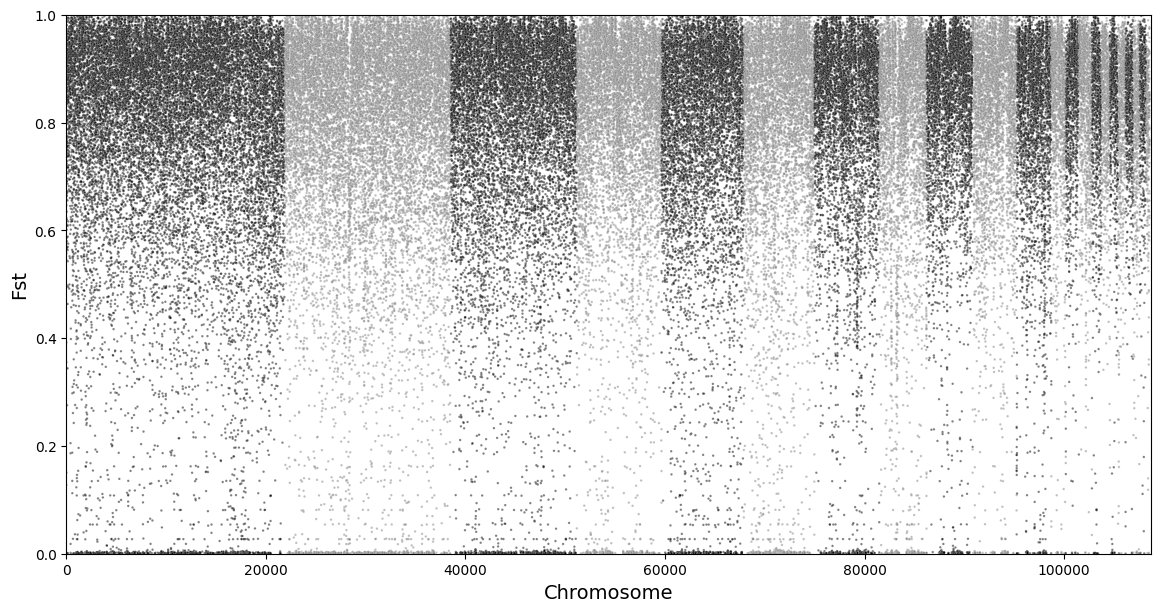

In [101]:
fst = pd.read_csv('angsd/distance/GLOBAL_whole-genome_fst2_50KBwindow_10KBstep.tsv', sep='\t', usecols=['chr', 'midPos', 'Nsites', 'FST'])

fst['x'] = range(len(fst))

plt.figure(figsize=(14,7))
palette=['black', 'grey']
ax=sns.scatterplot(data=fst, x='x', y='FST', hue='chr', palette=palette, alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome', fontsize=14)
ax.set_ylabel('Fst', fontsize=14)
ax.set_xlim(0, 108730)
ax.set_ylim(0, 1)

plt.savefig('plots/neutral_Fst_allChr.png')

### MDS
Figure out how to plot output from NGStools as MDS.  

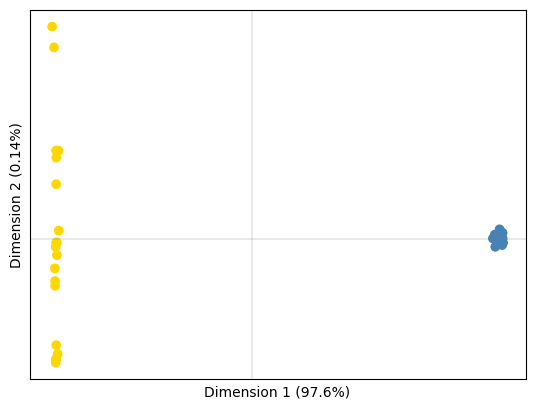

In [ ]:
mds = pd.read_csv('angsd/structure_MDS/GLOBAL_neutral.mds', sep='\t')
pops = pd.read_csv('angsd/structure_MDS/mds_pops.tsv', sep='\t', header=None)

color = ['gold'] * 19 + ['steelblue'] * 15

plt.scatter(mds['D1_97.5736950999342'], mds['D2_0.142602294031928'], c=color)
plt.axvline(x=sum(mds['D1_97.5736950999342']) / len(mds['D1_97.5736950999342']), color='grey', linewidth=0.25)
plt.axhline(y=sum(mds['D2_0.142602294031928']) / len(mds['D2_0.142602294031928']), color='grey', linewidth=0.25)
plt.xticks([])
plt.yticks([])
plt.xlabel('Dimension 1 (97.6%)')
plt.ylabel('Dimension 2 (0.14%)')
plt.savefig('plots/GLOBAL_neutral_MDS.png')

## Nucleotide diversity (π) 
Below we plot nucleotide diversity for both putatively neutral and all sites.  

C:\Users\Jana\AppData\Local\Temp\ipykernel_29756\332861318.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  au_neutralpi['Nucleotide Diversity'] = (au_neutralpi['tP'] / au_neutralpi['nSites'])
C:\Users\Jana\AppData\Local\Temp\ipykernel_29756\332861318.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ti_neutralpi['Nucleotide Diversity'] = (ti_neutralpi["tP"] / ti_neutralpi["nSites"])
C:\Users\Jana\AppData\Local\Temp\ipykernel_29756\332861318.py:12: SettingWithCopyWarning: 
A value is trying to be set o

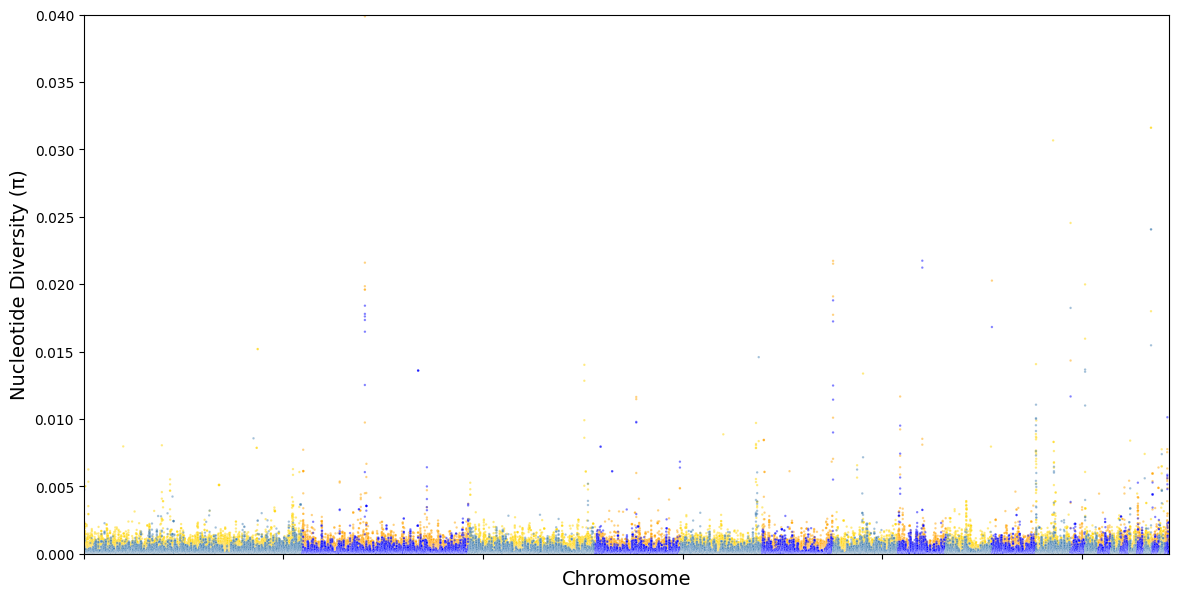

In [ ]:
cols=["Chr", "WinCenter", "tW", "tP", "tF", "tH", "tL", "Tajima", "fuf", "fud", "fayh", "zeng", "nSites"]
au_neutral = pd.read_csv('angsd/diversity/AU_pest_neutral_thetas_50KBwindows_10kbStep.pestPG', sep='\t', usecols=cols)
ti_neutral = pd.read_csv('angsd/diversity/TI_pest_neutral_thetas_50KBwindows_10KBstep.pestPG', sep='\t', usecols=cols)

au_neutralpi = au_neutral[['Chr', 'WinCenter', 'tP', 'nSites']]
ti_neutralpi = ti_neutral[['Chr', 'WinCenter', 'tP', 'nSites']]

au_neutralpi['Nucleotide Diversity'] = (au_neutralpi['tP'] / au_neutralpi['nSites'])
ti_neutralpi['Nucleotide Diversity'] = (ti_neutralpi["tP"] / ti_neutralpi["nSites"])
#print("The total nucleotide diverity for Australian fairy tern is", au_neutralpi['AU Nucleotide Diversity'].mean(), "While nucleotide diversity for tara iti is", ti_neutralpi['NZ Nucleotide Diversity'].mean())

au_neutralpi['x'] = range(len(au_neutralpi))
ti_neutralpi['x'] = range(len(ti_neutralpi))
#au_chr1 = au_neutralpi[au_neutralpi['Chr']=='CM020437.1_RagTag']
#ti_chr1 = ti_neutralpi[ti_neutralpi['Chr']=='CM020437.1_RagTag']

plt.figure(figsize=(14,7))
aupalette = ['gold', 'orange']
nzpalette = ['steelblue', 'blue']
ax = sns.scatterplot(data=au_neutralpi, x='x', y='Nucleotide Diversity', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False)
sns.scatterplot(data=ti_neutralpi, x='x', y='Nucleotide Diversity', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False)

ax.set_xlim(0, 108730)
ax.set_ylim(0, 0.04)
ax.set_xlabel('Chromosome', fontsize=14)
ax.set(xticklabels=[])
ax.set_ylabel('Nucleotide Diversity (π)', fontsize=14)

#plt.savefig('/mnt/g/My\ Data/S_nereis_ssp/genomic_data/plots/AU_nucleotideDiversity.png')
#plt.savefig('/mnt/g/My\ Data/S_nereis_ssp/genomic_data/plots/TI_nucleotideDiversity.png')
plt.savefig('plots/GLOBAL_nucleotideDiversity.png')

## Dxy estimates
Here we are estimating and plotting per site D<xub>XY</sub> for fairy tern population. 

In [ ]:
au_maf = pd.read_csv('angsd/diversity/AU_neutral_DXY.mafs', sep='\t')
ti_maf = pd.read_csv('angsd/diversity/TI_neutral_DXY.mafs', sep='\t')

maf = pd.merge(au_maf, ti_maf, on=['chromo',  'position', 'major', 'minor', 'ref', 'anc'])

maf['Dxy'] = (((maf['knownEM_x']) * (1 - maf['knownEM_y'])) + ((maf['knownEM_y']) * (1 - maf['knownEM_x'])))
sites=1655667
print('Global per site Dxy is:', (maf['Dxy'].sum()/sites).round(6))

maf_chr1 = maf[maf['chromo']=='CM020437.1_RagTag']

#maf['x'] = range(len(maf))

test = maf_chr1['Dxy'].rolling(100).mean()           # Trying to average across windows. Problem is that the sites calculated don't fall out in perfect 50KB window lengths.
test = test[100::100]                             # take every 5th row
test['x'] = range(len(maf_chr1))
#ax = sns.scatterplot(data=test, x='x', y='Dxy', alpha=0.5, s=3, legend=False)

#ax.set(xticklabels=[])

Global per site Dxy is: 0.027049


In [ ]:
import sys
INT_MIN = -sys.maxsize - 1

def maxSum(arr, n, k):
    # Initialize result
    max_sum = INT_MIN
    # Consider all blocks
    # starting with i.
    for i in range(n - k + 1):
        current_sum = 0
        for j in range(k):
            current_sum = current_sum + arr[i + j]
        # Update result if required.
        max_sum = max(current_sum, max_sum)
    return max_sum

maxSum(maf['Dxy'], len(maf), 50000)

## Chromosome 1 Tajima's D
Here we  plot Tajima's D estimates for Australian fairy tern and tara iti.  

C:\Users\Jana\AppData\Local\Temp\ipykernel_20708\3281064851.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  auTajima['x'] = range(len(auTajima))
C:\Users\Jana\AppData\Local\Temp\ipykernel_20708\3281064851.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tiTajima['x'] = range(len(tiTajima))
C:\Users\Jana\AppData\Local\Temp\ipykernel_20708\3281064851.py:8: UserWarning: 
The palette list has fewer values (2) than needed (22) and will cycle, which may produce an uninterpretable plot.
  ax = sns.scatterpl

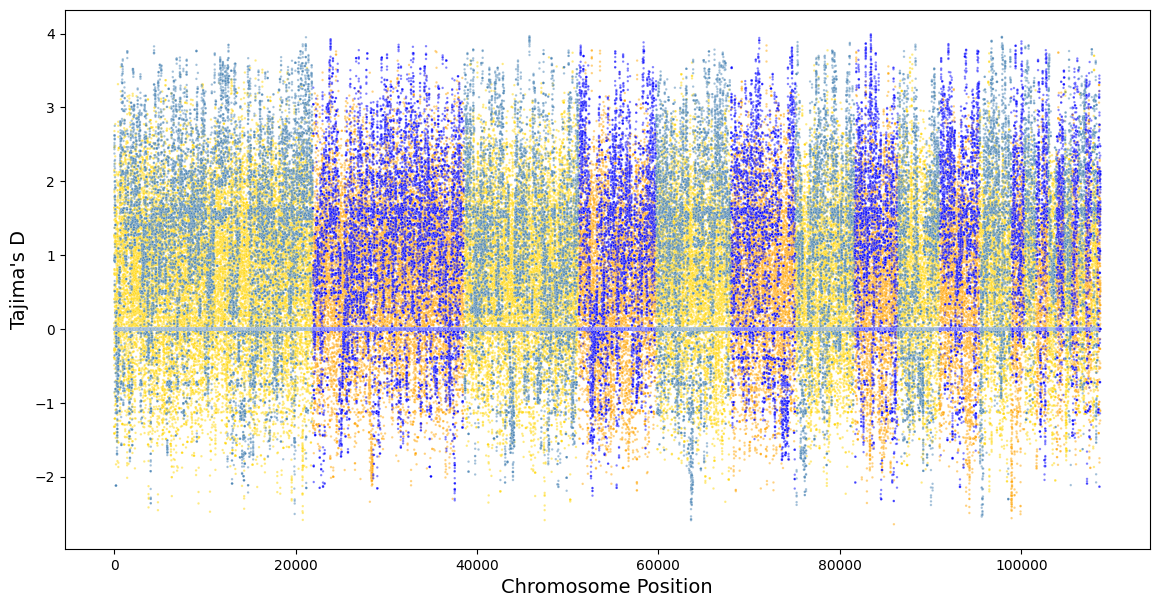

In [ ]:
auTajima = au_neutral[['Chr', 'WinCenter', 'Tajima', 'nSites']]
tiTajima = ti_neutral[['Chr', 'WinCenter', 'Tajima', 'nSites']]

auTajima['x'] = range(len(auTajima))
tiTajima['x'] = range(len(tiTajima))

plt.figure(figsize=(14,7))
ax = sns.scatterplot(data=auTajima, x='x', y='Tajima', hue='Chr', palette=aupalette, alpha=0.5, s=3, legend=False)
sns.scatterplot(data=tiTajima, x='x', y='Tajima', hue='Chr', palette=nzpalette, alpha=0.5, s=3, legend=False)

ax.set_xlabel('Chromosome Position', fontsize=14)
ax.set_ylabel("Tajima's D", fontsize=14)

#plt.savefig('data/plots/AU_Tajima_neutralSites.png')
#plt.savefig('data/plots/TI_Tajima_neutralSites.png')
plt.savefig('plots/GLOBAL_Tajima_neutralSites.png')